coggers is my favorite song from interstellar, let's see what it looks like

In [1]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np
import librosa as libr

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
coggers, sample_rate = libr.load('data/hans_zimmer/sample.wav', sr=8000, mono=False)
# coggers, sample_rate = libr.load('data/hans_zimmer/coggers.wav', sr=8000, mono=False)

In [3]:
# split the data into two tracks for separate training

a = coggers[0]
b = coggers[1]
del coggers

In [4]:
def take_sample(start, end):
    a = a[start*sample_rate : end*sample_rate]
    b = b[start*sample_rate : end*sample_rate]

    sample = np.stack((a,b)).T

    wav.write('data/hans_zimmer/sample.wav', sample_rate, sample)

# take_sample(start=155, end=165)

In [5]:
# HYPERPARAMETERS
SEQ_LEN = 0.5 # this is in seconds
SEQ_LEN = int(SEQ_LEN * sample_rate)
print(SEQ_LEN)

# gonna list some powers of 2 here for reference
# 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152
HIDDEN_DIM = 2048
N_LAYERS = 3

OUT_DIM = 2

EPOCHS = 1
LR = 0.0001

4000


In [6]:
scaler_a = MinMaxScaler(feature_range=(-1,1))
scaler_b = MinMaxScaler(feature_range=(-1,1))

a = scaler_a.fit_transform(a.reshape(-1,1))
b = scaler_b.fit_transform(b.reshape(-1,1))

In [7]:
a = torch.tensor(a).cuda().float()
b = torch.tensor(b).cuda().float()

In [8]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layers, out_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x, h = self.lstm(x.view(len(x),1,-1))
        x = self.fc1(x)
        return x

In [9]:
model_a = LSTM(SEQ_LEN, HIDDEN_DIM, N_LAYERS, OUT_DIM).cuda()
model_b = LSTM(SEQ_LEN, HIDDEN_DIM, N_LAYERS, OUT_DIM).cuda()

In [10]:
def train(n='cp'):
    losses_a = []
    losses_b = []

    optimizer_a = optim.Adam(model_a.parameters(), lr=LR)
    optimizer_b = optim.Adam(model_b.parameters(), lr=LR)

    loss_fn_a = nn.MSELoss()
    loss_fn_b = nn.MSELoss()

    for epoch in range(EPOCHS):
        for i in tqdm(  range(  int((len(a)-SEQ_LEN)/OUT_DIM)  )  ):
            Xa = a[i*OUT_DIM : i*OUT_DIM + SEQ_LEN]
            Ya = a[i*OUT_DIM+SEQ_LEN : (i+1)*OUT_DIM + SEQ_LEN]

            Xa = Xa.view(-1, SEQ_LEN)

            out_a = model_a(Xa)
            loss_a = loss_fn_a(out_a, Ya)

            model_a.zero_grad()
            loss_a.backward()
            optimizer_a.step()
            losses_a.append(loss_a.item())

            
            Xb = b[i:i+SEQ_LEN]
            Yb = b[i+SEQ_LEN]

            Xb = Xb.view(-1, SEQ_LEN)


            out_b = model_b(Xb)
            loss_b = loss_fn_b(out_b, Yb)

            model_b.zero_grad()
            loss_b.backward()
            optimizer_b.step()
            losses_b.append(loss_b)
            
            if i%1000==0:
                torch.save(model_a.state_dict(), f'models/hans_zimmer/checkpoints/{n}_a.pt')
                torch.save(model_b.state_dict(), f'models/hans_zimmer/checkpoints/{n}_b.pt')
    plt.plot(losses_a)
    plt.plot(losses_b)
    plt.show()

In [11]:
def load(n):
    model_a.load_state_dict(torch.load(f'models/hans_zimmer/{n}_a.pt'))
    model_b.load_state_dict(torch.load(f'models/hans_zimmer/{n}_b.pt'))
def save(n):
    torch.save(model_a.state_dict(), f'models/hans_zimmer/{n}_a.pt')
    torch.save(model_b.state_dict(), f'models/hans_zimmer/{n}_b.pt')

In [12]:
def predict():
    pred_a = np.array([])
    pred_b = np.array([])

    for i in tqdm(  range(  int((len(a)-SEQ_LEN)/OUT_DIM)  )  ):
        Xa = a[i*OUT_DIM : i*OUT_DIM + SEQ_LEN]
        Xb = b[i*OUT_DIM : i*OUT_DIM + SEQ_LEN]

        Xa = Xa.view(-1, SEQ_LEN)
        Xb = Xb.view(-1, SEQ_LEN)

        out_a = model_a(Xa).squeeze().cpu()
        out_b = model_b(Xb).squeeze().cpu()

        out_a = out_a.detach().numpy()
        out_b = out_b.detach().numpy()

        pred_a = np.concatenate((pred_a, out_a))
        pred_b = np.concatenate((pred_b, out_b))

    pred_a = scaler_a.inverse_transform(pred_a.reshape(-1,1))
    pred_b = scaler_b.inverse_transform(pred_b.reshape(-1,1))

    song = np.stack((pred_a.squeeze(), pred_b.squeeze()))

    wav.write('data/hans_zimmer/out.wav', sample_rate, song.T)

100%|██████████| 38000/38000 [1:00:49<00:00, 10.41it/s]


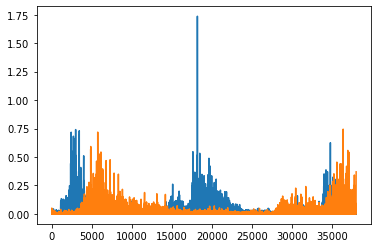

100%|██████████| 38000/38000 [02:32<00:00, 249.66it/s]


In [13]:
# load('checkpoints/ten')
train()
predict()

In [14]:
save('act1')

In [23]:
def generate(length, n):
    # im not creative so im just calling the generated sequences A and B
    A = a[:SEQ_LEN].cpu().numpy().squeeze()
    B = b[:SEQ_LEN].cpu().numpy().squeeze()

    for i in tqdm(range(int((length-SEQ_LEN)/OUT_DIM))):
        Xa = A[-SEQ_LEN:]
        Xb = B[-SEQ_LEN:]

        Xa = torch.tensor(Xa).cuda().float().view(-1, SEQ_LEN)
        Xb = torch.tensor(Xb).cuda().float().view(-1, SEQ_LEN)

        out_a = model_a(Xa).squeeze().cpu()
        out_b = model_a(Xb).squeeze().cpu()

        out_a = out_a.detach().numpy()
        out_b = out_b.detach().numpy()

        A = np.concatenate((A, out_a))
        B = np.concatenate((B, out_b))
    
    A = scaler_a.inverse_transform(A.reshape(-1,1))
    B = scaler_b.inverse_transform(B.reshape(-1,1))

    song = np.stack((A.squeeze(), B.squeeze()))

    wav.write(f'data/hans_zimmer/{n}.wav', sample_rate, song.T)

In [24]:
generate(80000, 'gen')

100%|██████████| 38000/38000 [02:35<00:00, 244.30it/s]


doesn't exactly sound great but will do for now 